# Fake News Detection



In an era of rapid digital information spread distinguishing real from fake news is challenging. The Fake News Detection Dataset helps researchers and data scientists train models for accurate fake news detection.

# SetUp

In [41]:
import matplotlib.pyplot as plt
import os
import re
import random
import numpy as np
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.18.0


# Explore the Data



## Upzip data

In [7]:
DATA_PATH = "fake_and_real_news.zip"
EXPORT_PATH = 'fake_and_real_news'

# Check if the file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}. Please download the data and place it in the current working directory.")

# If the file exists, proceed to extract it
# Instead of using tf.keras.utils.get_file, use zipfile to extract the data
import zipfile

with zipfile.ZipFile(DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXPORT_PATH) # Extract to the current working directory

## Load Data

```
fake_and_real_news/
...Fake/
......news_article_1.txt
......news_article_2.txt
...Real/
......news_article_1.txt
......news_article_2.txt
```



In [6]:
# batch_size = 32
SEED = 42

In [8]:
# First split: Train (70%) and Temp (30% for val & test)
train_ds = tf.keras.utils.text_dataset_from_directory(
    EXPORT_PATH,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='training'
)

raw_val_test_ds = tf.keras.utils.text_dataset_from_directory(
    EXPORT_PATH,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='validation'
)

# Second split: Val (20%) and Test (10%)
val_size = int(0.67 * len(raw_val_test_ds))  # 67% of 30% = 20%
test_size = len(raw_val_test_ds) - val_size  # Remaining 10%

val_ds = raw_val_test_ds.take(val_size)
test_ds = raw_val_test_ds.skip(val_size)

# Print dataset sizes
print('\n')
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")


Found 9900 files belonging to 2 classes.
Using 6930 files for training.
Found 9900 files belonging to 2 classes.
Using 2970 files for validation.


Train size: 6930
Validation size: 1989
Test size: 981


## Check the Data

In [9]:
for text_batch, label_batch in train_ds.take(5):
  print("Article", text_batch.numpy())
  print("Label", label_batch.numpy())

Article b' Hawaii Attorney General HUMILIATES Jeff Sessions For Whining About Judge On \xe2\x80\x98Island In The Pacific\xe2\x80\x99 Donald Trump s Attorney General just got schooled on the Constitution.Earlier this week, Jeff Sessions bitched about a judge  on an island in the Pacific  having the power to block an executive order. I really am amazed that a judge sitting on an island in the Pacific can issue an order that stops the President of the United States from what appears to be clearly his statutory and constitutional power,  Sessions said.Of course, Sessions is a hypocrite because he cheered on judges who blocked executive orders issued by President Obama.But because the order was issued by his rich white boss, Sessions is all of a sudden complaining.Judge Derrick Watson stood up to Trump and his racist administration a couple months ago by blocking parts of the immigration ban that barred Muslims from certain nations from entering the country. Trump s ban caused international

In [12]:
for index,val in enumerate(train_ds.class_names):
  print(f"Label {index} corresponds to {val}")

Label 0 corresponds to Fake
Label 1 corresponds to Real



## Collect Key Metrics

In [34]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def plot_class_distribution(labels):
    """Plots the class distribution.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = len(list(set(train_label.tolist())))
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [13]:
# Number of samples: Total number of examples you have in the data.
print(len(train_ds))

6930


In [14]:
# Number of classes: Total number of topics or categories in the data.
print(len(train_ds.class_names))

2


In [15]:
# Iterate through the dataset and convert to NumPy arrays
def convert_dataset_to_numpy(dataset):
    texts = []
    labels = []
    for text, label in dataset:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(label.numpy())
    return np.array(texts), np.array(labels)

In [16]:
train_text, train_label = convert_dataset_to_numpy(train_ds)
val_text, val_label = convert_dataset_to_numpy(val_ds)
test_text, test_label = convert_dataset_to_numpy(test_ds)

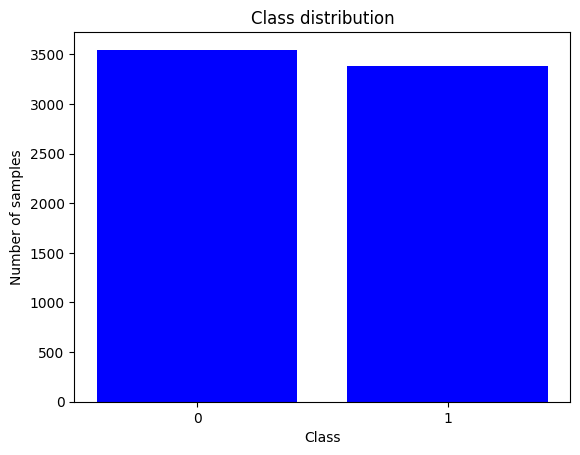

In [29]:
# Number of samples per class: Number of samples per class (topic/category).
plot_class_distribution(train_label)

In [31]:
# Number of words per sample: Median number of words in one sample.
print(get_num_words_per_sample(train_text))

405.0


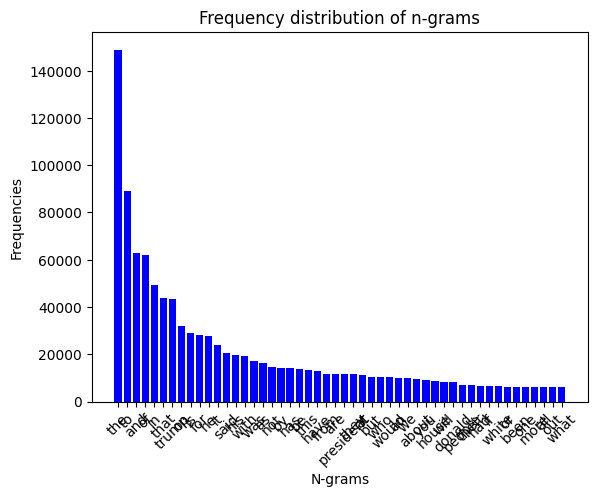

In [35]:
# Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
plot_frequency_distribution_of_ngrams(train_text)

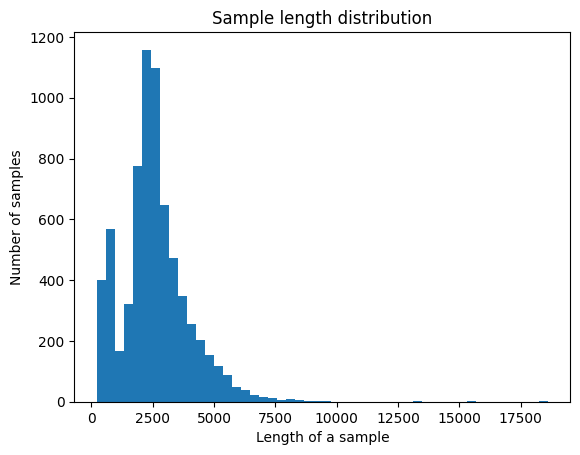

In [36]:
# Distribution of sample length: Distribution showing the number of words per sample in the dataset.
plot_sample_length_distribution(train_text)

# Choose a Model

In [37]:
# Calculate the number of samples/number of words per sample ratio.
number_of_samples = len(train_text)
number_of_words_per_sample = get_num_words_per_sample(train_text)
ratio = number_of_samples / number_of_words_per_sample
print(int(ratio))

17


# Data Preprocessing

1. tokenization
2. vectorization
3. feature selection

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)


# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts, test_texts, top_k=5000):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')

    return x_train, x_val,x_test

In [39]:
x_train, x_val, x_test = ngram_vectorize(train_text, train_label, val_text, test_text)

# Build Model

In [42]:
# Build MLP model
def build_mlp(input_shape):
    model = Sequential([
        Dropout(0.2, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [43]:
model = build_mlp(x_train.shape[1:])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train Model

In [44]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
history = model.fit(x_train, train_label, epochs=100, batch_size=32,
                     validation_data=(x_val, val_label), callbacks=[early_stop], verbose=2)


Epoch 1/100
217/217 - 3s - 13ms/step - accuracy: 0.9749 - loss: 0.2695 - val_accuracy: 0.9874 - val_loss: 0.0771
Epoch 2/100
217/217 - 2s - 9ms/step - accuracy: 0.9921 - loss: 0.0494 - val_accuracy: 0.9915 - val_loss: 0.0358
Epoch 3/100
217/217 - 1s - 6ms/step - accuracy: 0.9948 - loss: 0.0258 - val_accuracy: 0.9935 - val_loss: 0.0223
Epoch 4/100
217/217 - 3s - 12ms/step - accuracy: 0.9984 - loss: 0.0149 - val_accuracy: 0.9955 - val_loss: 0.0152
Epoch 5/100
217/217 - 3s - 12ms/step - accuracy: 0.9991 - loss: 0.0099 - val_accuracy: 0.9965 - val_loss: 0.0119
Epoch 6/100
217/217 - 1s - 6ms/step - accuracy: 0.9997 - loss: 0.0063 - val_accuracy: 0.9975 - val_loss: 0.0090
Epoch 7/100
217/217 - 2s - 8ms/step - accuracy: 0.9999 - loss: 0.0044 - val_accuracy: 0.9975 - val_loss: 0.0075
Epoch 8/100
217/217 - 1s - 7ms/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 9/100
217/217 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9985 - val_lo

# Evaluate the model

In [45]:
loss, accuracy = model.evaluate(x_test, np.array(test_label), verbose=2)


print("Loss: ", loss)
print("Accuracy: ", accuracy)

31/31 - 0s - 5ms/step - accuracy: 0.9969 - loss: 0.0046
Loss:  0.004580005072057247
Accuracy:  0.9969419240951538


In [46]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

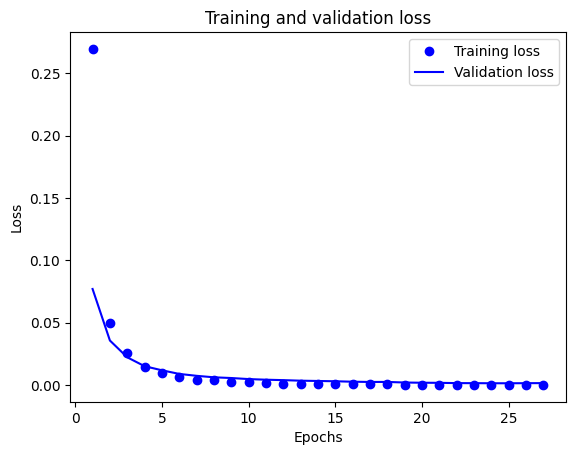

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

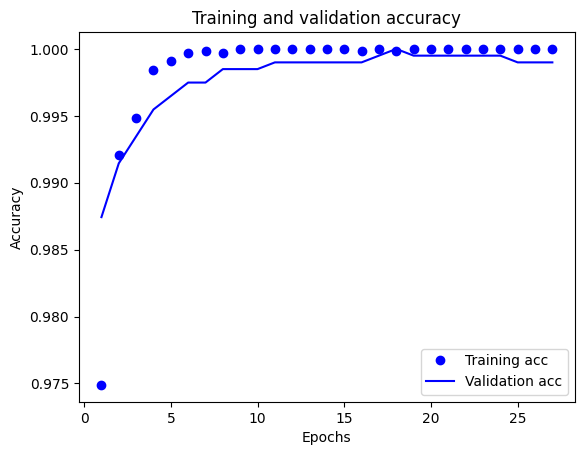

In [48]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Save Model

In [49]:
# Save model.
model.save('Fake_News_Detector_model.h5')